In [1]:
# Importing the required Libraries
import numpy as np
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import itertools
import os
import glob
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
train_path = "/kaggle/input/tomatoleafdisease/Tomato Leaf Diseases - Copy/Training Set"
valid_path = "/kaggle/input/tomatoleafdisease/Tomato Leaf Diseases - Copy/Validation Set"
test_path = "/kaggle/input/tomatoleafdisease/Tomato Leaf Diseases - Copy/Testing set"

In [3]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True, 
                                   vertical_flip=True)

valid_datagen = ImageDataGenerator(rescale = 1./255)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [4]:
# Augmenting training data for more training examples
training_set = train_datagen.flow_from_directory("/kaggle/input/tomatoleafdisease/Tomato Leaf Diseases - Copy/Training Set",
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 9500 images belonging to 10 classes.


In [5]:
validation_set = valid_datagen.flow_from_directory("/kaggle/input/tomatoleafdisease/Tomato Leaf Diseases - Copy/Validation Set",
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 7000 images belonging to 10 classes.


In [6]:
iv3_model=tf.keras.applications.inception_v3.InceptionV3(weights='imagenet', 
                                                         include_top=False, 
                                                         input_shape = (224, 224, 3),
                                                         pooling='avg')

87924736/87910968 [==============================] - 1s 0us/step


In [7]:
iv3_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

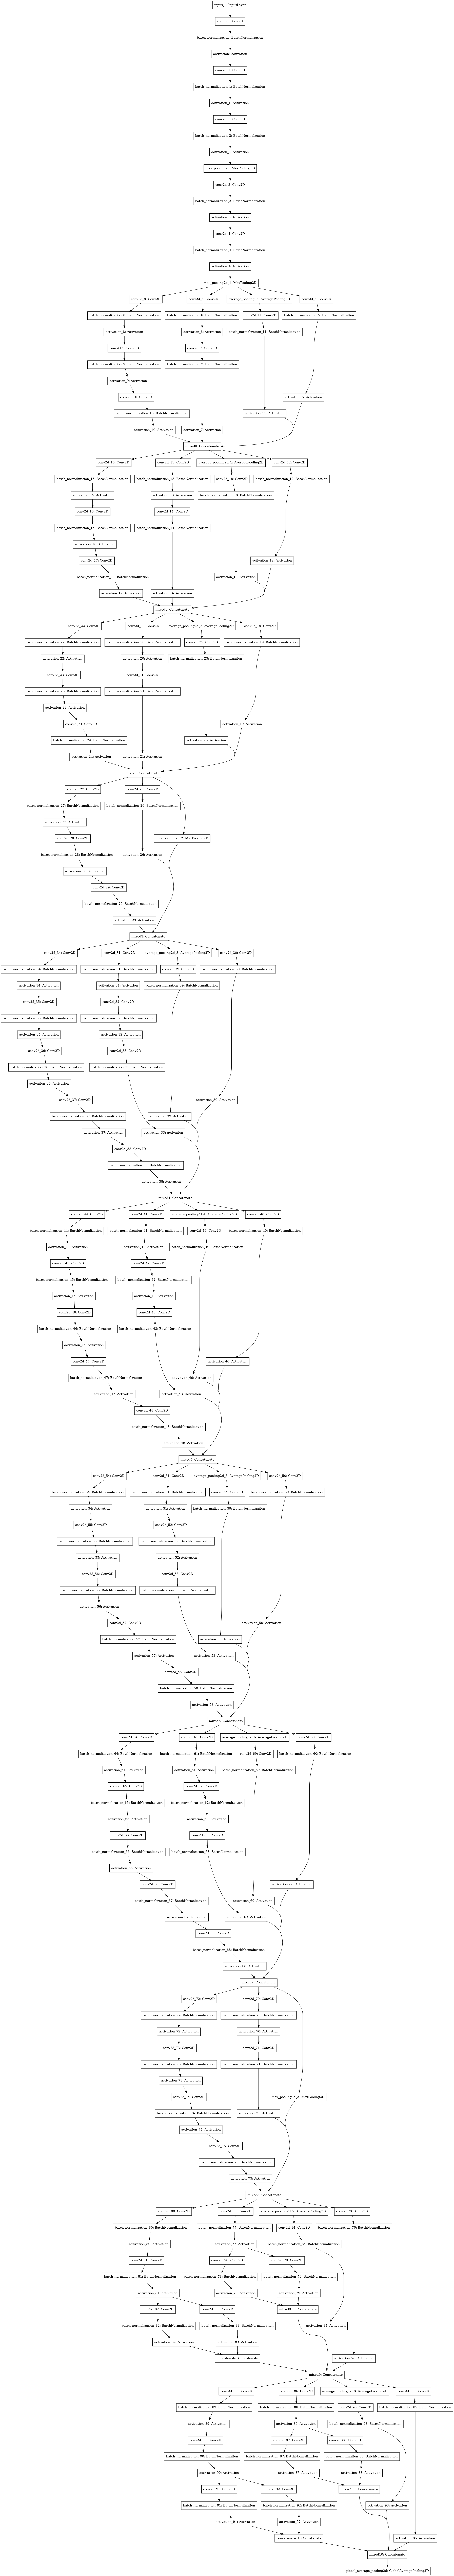

In [8]:
plot_model(iv3_model)

In [9]:
iv3model = Sequential()
iv3model.add(iv3_model)
#iv3model.add(Flatten())
iv3model.add(Dense(2048,activation="relu"))
iv3model.add(Dense(4096,activation="relu"))
iv3model.add(Dense(10, activation="softmax"))
iv3model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 2048)              21802784  
_________________________________________________________________
dense (Dense)                (None, 2048)              4196352   
_________________________________________________________________
dense_1 (Dense)              (None, 4096)              8392704   
_________________________________________________________________
dense_2 (Dense)              (None, 10)                40970     
Total params: 34,432,810
Trainable params: 34,398,378
Non-trainable params: 34,432
_________________________________________________________________


In [10]:
iv3model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

In [11]:
model_save = ModelCheckpoint('./iv3.h5', 
                             save_best_only = True, 
                             save_weights_only = False,
                             monitor = 'val_loss', 
                             mode = 'min', verbose = 1)
early_stop = EarlyStopping(monitor = 'val_loss', min_delta = 0.001, 
                           patience = 10, mode = 'min', verbose = 1,
                           restore_best_weights = True)
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.3, 
                              patience = 2, min_delta = 0.001, 
                              mode = 'min', verbose = 1)
model = iv3model.fit(x = training_set, validation_data=validation_set, epochs=20, callbacks = [model_save, early_stop, reduce_lr])

Epoch 1/20
297/297 [==============================] - 273s 873ms/step - loss: 1.3689 - accuracy: 0.5129 - val_loss: 5.0945 - val_accuracy: 0.2851

Epoch 00001: val_loss improved from inf to 5.09448, saving model to ./iv3.h5
Epoch 2/20
297/297 [==============================] - 150s 506ms/step - loss: 0.5769 - accuracy: 0.8178 - val_loss: 1.8762 - val_accuracy: 0.5096

Epoch 00002: val_loss improved from 5.09448 to 1.87621, saving model to ./iv3.h5
Epoch 3/20
297/297 [==============================] - 150s 504ms/step - loss: 0.3860 - accuracy: 0.8820 - val_loss: 0.8850 - val_accuracy: 0.7871

Epoch 00003: val_loss improved from 1.87621 to 0.88495, saving model to ./iv3.h5
Epoch 4/20
297/297 [==============================] - 150s 504ms/step - loss: 0.2912 - accuracy: 0.9083 - val_loss: 0.7179 - val_accuracy: 0.7770

Epoch 00004: val_loss improved from 0.88495 to 0.71791, saving model to ./iv3.h5
Epoch 5/20
297/297 [==============================] - 149s 501ms/step - loss: 0.2652 - accur

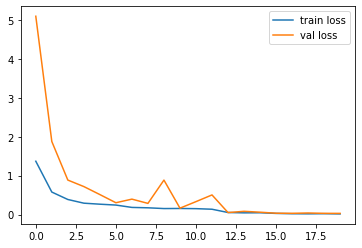

In [12]:
# Loss Plot
plt.plot(model.history['loss'], label='train loss')
plt.plot(model.history['val_loss'], label='val loss')
plt.legend()
plt.show()

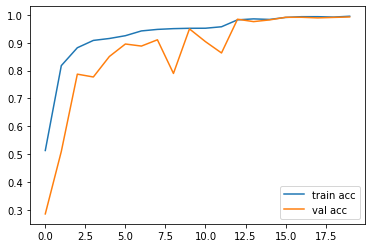

In [13]:
# accuracy plot
plt.plot(model.history['accuracy'], label='train acc')
plt.plot(model.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()

In [14]:
print("training_accuracy", model.history['accuracy'][-1])
print("validation_accuracy", model.history['val_accuracy'][-1])

training_accuracy 0.9951578974723816
validation_accuracy 0.9925714135169983


In [15]:
test_set = test_datagen.flow_from_directory("/kaggle/input/tomatoleafdisease/Tomato Leaf Diseases - Copy/Testing set",
                                            target_size = (224, 224),
                                            batch_size = 500,
                                            class_mode = 'categorical')

Found 500 images belonging to 10 classes.


In [16]:
test_data, test_labels = test_set.next()

In [17]:
test_scores = iv3model.evaluate(test_data, test_labels)
print("Test Accuracy: ",(test_scores[1]))

16/16 [==============================] - 3s 73ms/step - loss: 0.0107 - accuracy: 0.9960
Test Accuracy:  0.9959999918937683


In [18]:
y_pred_test=iv3model.predict(test_data).argmax(axis=1)
print(y_pred_test)

[5 9 6 6 6 2 8 4 3 7 5 1 3 9 7 4 3 6 8 6 6 9 9 3 9 4 6 8 7 0 0 5 8 7 2 6 8
 6 3 9 1 7 5 6 2 9 4 5 2 6 8 7 5 1 5 0 6 0 5 5 3 2 5 6 4 1 0 1 1 9 6 7 6 7
 3 4 5 0 3 2 9 8 0 2 7 3 8 8 6 3 3 1 0 6 4 1 6 8 3 6 9 6 7 0 2 8 1 0 5 7 7
 0 1 9 0 3 4 1 7 2 9 4 8 4 3 8 4 7 6 0 2 0 8 0 3 0 1 1 9 9 1 2 2 3 3 7 5 3
 1 1 5 6 9 3 7 0 0 5 6 9 6 2 3 7 9 2 1 5 4 3 4 1 0 4 4 8 7 3 4 7 2 4 9 4 9
 7 9 9 8 5 5 4 9 2 1 7 6 8 0 1 8 9 6 8 1 0 2 9 0 4 1 9 1 7 9 7 6 7 1 1 5 9
 7 5 8 9 1 1 7 8 2 5 5 0 4 2 8 6 5 6 2 1 9 4 7 8 1 9 9 3 3 0 7 8 6 5 2 4 2
 0 3 0 0 0 3 0 7 8 2 9 9 0 2 4 0 5 7 7 3 7 1 3 2 0 7 7 5 1 5 4 8 4 5 2 2 5
 7 8 8 8 9 3 3 6 0 4 4 5 2 3 6 8 0 5 3 1 1 9 4 2 6 8 4 3 8 4 6 9 0 7 5 1 6
 1 0 0 3 1 5 5 2 4 1 2 7 4 8 7 0 0 0 0 4 3 1 8 8 9 6 3 1 8 8 2 4 5 1 1 6 3
 9 0 7 7 6 9 6 5 8 2 2 4 3 7 2 5 2 0 3 2 9 7 6 6 4 2 8 3 8 6 5 4 9 5 6 3 2
 6 1 1 7 7 1 2 9 3 4 5 3 7 5 4 0 3 1 4 2 1 8 2 2 3 7 6 8 0 9 5 3 5 8 6 7 3
 9 0 8 5 4 9 0 8 8 7 5 8 0 6 9 8 5 2 4 6 4 2 0 1 5 9 2 6 5 1 2 5 7 4 2 1 4
 6 7 1 3 4 9 3 8 9 9 4 6 

In [19]:
#Predicting the test data

pred_labels = iv3model.predict(test_data)
def roundoff(arr):
    arr[np.argwhere(arr != arr.max())] = 0
    arr[np.argwhere(arr == arr.max())] = 1
    return arr

for labels in pred_labels:
    labels = roundoff(labels)

print(classification_report(test_labels, pred_labels))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99        50
           1       1.00      1.00      1.00        50
           2       1.00      1.00      1.00        50
           3       1.00      1.00      1.00        50
           4       1.00      1.00      1.00        50
           5       1.00      0.98      0.99        50
           6       0.96      1.00      0.98        50
           7       1.00      1.00      1.00        50
           8       1.00      1.00      1.00        50
           9       1.00      1.00      1.00        50

   micro avg       1.00      1.00      1.00       500
   macro avg       1.00      1.00      1.00       500
weighted avg       1.00      1.00      1.00       500
 samples avg       1.00      1.00      1.00       500



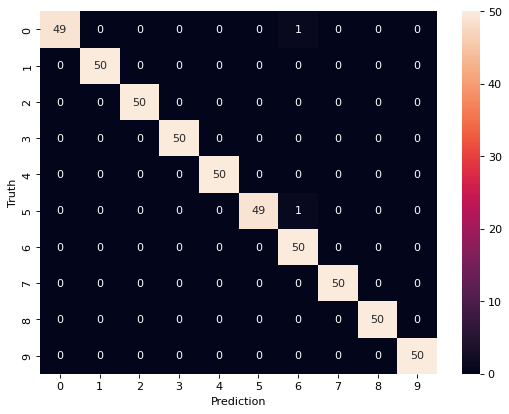

In [20]:
pred_ls = np.argmax(pred_labels, axis=1)
test_ls = np.argmax(test_labels, axis=1)

conf_arr = confusion_matrix(test_ls, pred_ls)

plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

ax = sns.heatmap(conf_arr, annot=True, fmt='d')
plt.xlabel('Prediction')
plt.ylabel('Truth')
plt.show(ax)

In [21]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
# model = load_model("my_best_model.hdf5")
img = image.load_img('/kaggle/input/tomatoleafdisease/Tomato Leaf Diseases - Copy/Testing set/Tomato___Late_blight/image (902).JPG', target_size=(224,224))
x = image.img_to_array(img)/255
x = np.expand_dims(x, axis=0)
classes = iv3model.predict(x)
print (classes)
# predicting images
#image = image.convert("RGB")
result = np.argmax(classes)
dic=dict(training_set.class_indices)
print([key for key in dic.keys()][result]) 

[[1.4443330e-06 2.0371537e-05 9.9997389e-01 7.8946465e-07 2.5416443e-06
  3.7105227e-08 2.2189280e-08 3.7500463e-08 1.5463313e-11 8.8439037e-07]]
Tomato___Late_blight
